In [4]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split,KFold,cross_validate
import numpy as np
from sklearn.metrics import precision_score,roc_auc_score,accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# import seaborn as sns
import io
# from google.colab import files


# uploaded = files.upload()
# #extract the data
# raw_df = pd.read_csv(io.BytesIO(uploaded['BitcoinHeistData.csv']))


# #extract the data
raw_df = pd.read_csv('~/ML_class_projects/a_1/Skin_NonSkin.txt', delimiter='	')
cleaned_df = raw_df.copy()


cleaned_df['class']=np.array([1 if x==1 else 0 for x in cleaned_df['class']])
print(cleaned_df.head(5))
#summarize data distribution
y=np.array(cleaned_df['class'])
X=np.array(cleaned_df.iloc[:,:-1])
print(Counter(y))

#rescale data
scaler = StandardScaler()
X = scaler.fit_transform(X)


   val1  val2  val3  class
0    74    85   123      1
1    73    84   122      1
2    72    83   121      1
3    70    81   119      1
4    70    81   119      1
Counter({0: 194198, 1: 50859})


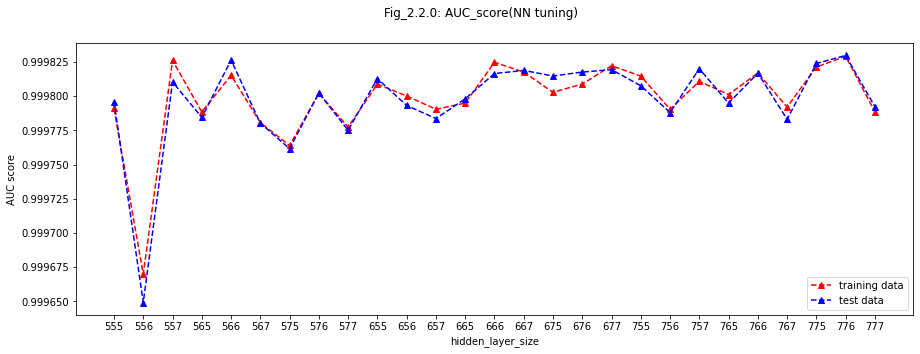

In [5]:
###########Cross-validation to find a good hidden_layer_size#################

t=10
cv = KFold(n_splits=t,shuffle=True)

##cross validation to find out the best hidden_layer_size using kd_tree###
AUC_train_score_list=[]
AUC_test_score_list=[]


hidden_layer_sizes = [(i,j,k) for i in range(5,8) for j in range(5,8) for k in range(5,8)]

# parameters=(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)[source]
for hidden_layer_size in hidden_layer_sizes:
    MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_size,activation ='tanh',solver='sgd',max_iter=200)
    scores =  cross_validate(MLP, X, y, scoring=['roc_auc'], cv=cv, n_jobs=-1,return_train_score=True)
    AUC_train_score_list.append(sum(scores['train_roc_auc'])/t)
    AUC_test_score_list.append(sum(scores['test_roc_auc'])/t)

#generate Fig_2.2.0 tunning graph#######
# m = len(hidden_layer_sizes)
hidden_layer_sizes_text=[str(hidden_layer_size[0])+str(hidden_layer_size[1])+str(hidden_layer_size[2]) for hidden_layer_size in hidden_layer_sizes]
fig_0, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
axs[0].plot(hidden_layer_sizes_text[:10],AUC_train_score_list[:10],"r^",linestyle = "--",label='training data')
axs[0].plot(hidden_layer_sizes_text[:10],AUC_test_score_list[:10],"b^",linestyle = "--",label='test data')
axs[1].plot(hidden_layer_sizes_text[10:21],AUC_train_score_list[10:21],"r^",linestyle = "--",label='training data')
axs[1].plot(hidden_layer_sizes_text[10:21],AUC_test_score_list[10:21],"b^",linestyle = "--",label='test data')

axs[2].plot(hidden_layer_sizes_text[21:],AUC_train_score_list[21:],"r^",linestyle = "--",label='training data')
axs[2].plot(hidden_layer_sizes_text[21:],AUC_test_score_list[21:],"b^",linestyle = "--",label='test data')
axs[0].set_xlabel("hidden_layer_size")
axs[0].set_ylabel("AP_score")
axs[1].set_xlabel("hidden_layer_size")
axs[1].set_ylabel("AP_score")
axs[2].set_xlabel("hidden_layer_size")
axs[2].set_ylabel("AP_score")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig_0.suptitle("Fig_2.2.0: AUC_score(NN tuning)")
fig_0.savefig("NN_fig_2.2_tunning:AUC_score.png")

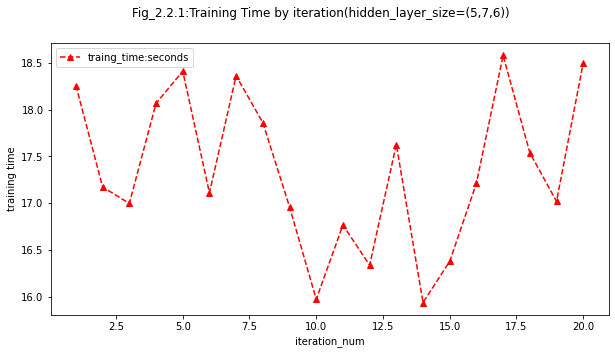

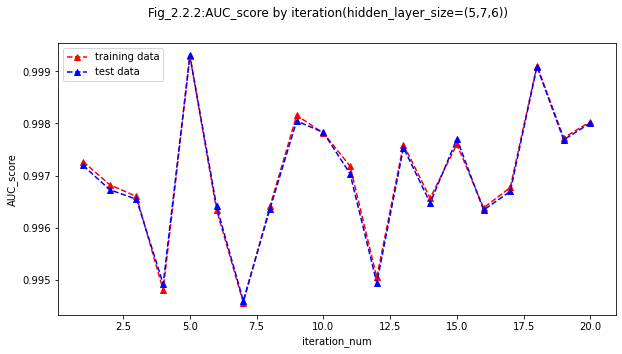

In [9]:
###################Plot the learning curve by iteration with the parameter hidden_layer_size=(5,7,6)############
AUC_train_score_by_iteration=[]
AUC_test_score_by_iteration=[]
training_time_by_iteration=[]
for iteration_num in range(20):
    MLP = MLPClassifier(hidden_layer_sizes=(5,7,6),activation ='tanh',solver='sgd',max_iter=10,warm_start=True)
    scores =  cross_validate(MLP, X, y, scoring=['roc_auc'], cv=cv, n_jobs=-1,return_train_score=True)
    training_time_by_iteration.append(sum(scores['fit_time'])/t)
    AUC_train_score_by_iteration.append(sum(scores['train_roc_auc'])/t)
    AUC_test_score_by_iteration.append(sum(scores['test_roc_auc'])/t)

##generate Fig_2.2,1, Fig_2.2.2#########
iteration_num = range(1,21)
fig_1, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
axs.plot(iteration_num,training_time_by_iteration,"r^",linestyle = "--",label="traing_time:seconds")
axs.set_xlabel("iteration_num")
axs.set_ylabel("training time")
axs.legend()
fig_1.suptitle("Fig_2.2.1:Training Time by iteration(hidden_layer_size=(5,7,6))")
fig_1.savefig("NN_fig_2.2:training_time by iteration.png")


fig_2,axs = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
axs.plot(iteration_num,AUC_train_score_by_iteration,"r^",linestyle = "--", label='training data')
axs.plot(iteration_num,AUC_test_score_by_iteration,"b^",linestyle = "--",label='test data')
axs.set_xlabel("iteration_num")
axs.set_ylabel("AUC_score")
fig_2.suptitle('Fig_2.2.2:AUC_score by iteration(hidden_layer_size=(5,7,6))')
axs.legend()
fig_2.savefig("NN_fig_2.2:AUC Scores by iteration.png")


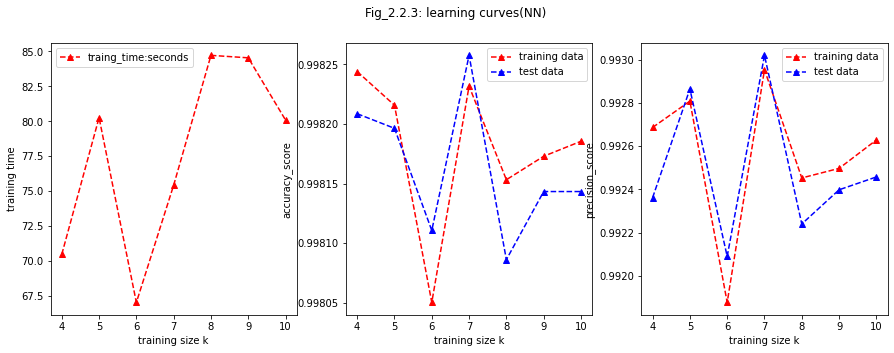

In [11]:
###############learning curves with training size################
Accuracy_train_score=[]
Accuracy_test_score=[]
Precision_test_score=[]
Precision_train_score=[]
training_time = []

for k in range(4,11):
    cv = KFold(n_splits=k,shuffle=True)
    MLP = MLPClassifier(hidden_layer_sizes=(5,7,6),activation ='tanh',solver='sgd',max_iter=50)
    scores =  cross_validate(MLP, X, y, scoring=['accuracy','precision'], cv=cv, n_jobs=-1,return_train_score=True)
    
    training_time.append(sum(scores['fit_time'])/k)
    Accuracy_train_score.append(sum(scores['train_accuracy'])/k)
    Accuracy_test_score.append(sum(scores['test_accuracy'])/k)
    Precision_train_score.append(sum(scores['train_precision'])/k)
    Precision_test_score.append(sum(scores['test_precision'])/k)

##genearte Fig_2.2.3 learning curves with traning size#######
K= range(4,11)
fig_3, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
axs[0].plot(K,training_time,"r^",linestyle = "--",label="traing_time:seconds")
axs[0].set_xlabel("training size k")
axs[0].set_ylabel("training time")
axs[1].plot(K,Accuracy_train_score,"r^",linestyle = "--",label='training data')
axs[1].plot(K,Accuracy_test_score,"b^",linestyle = "--",label='test data')
axs[1].set_xlabel("training size k")
axs[1].set_ylabel("accuracy_score")
axs[2].plot(K,Precision_train_score,"r^",linestyle = "--",label='training data')
axs[2].plot(K,Precision_test_score,"b^",linestyle = "--",label='test data')
axs[2].set_xlabel("training size k")
axs[2].set_ylabel("precision_score")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig_3.suptitle("Fig_2.2.3: learning curves(NN)")
fig_3.savefig("NN_fig_2.2_trainnig:learning curves.png")

In [15]:
##################prediction results, generate the data in table2.2.0#########
cv = KFold(n_splits=7,shuffle=True)
MLP = MLPClassifier(hidden_layer_sizes=(5,7,6),activation ='tanh',solver='sgd',max_iter=50)
scores =  cross_validate(MLP, X, y, scoring=['precision','accuracy'], cv=cv, n_jobs=-1,return_train_score=True)
print("The accuracy scores on training set and test set are",sum(scores['train_accuracy'])/7,sum(scores['test_accuracy'])/7)
print("The precision scores on training set and test set are",sum(scores['train_precision'])/7,sum(scores['test_precision'])/7)


The accuracy scores on training set and test set are 1.7468424014956507 1.7468435918694685
The precision scores on training set and test set are 1.7368157123634569 1.7367281205230305


In [16]:
print("The accuracy scores on training set and test set are",sum(scores['train_accuracy'])/7,sum(scores['test_accuracy'])/7)
print("The precision scores on training set and test set are",sum(scores['train_precision'])/7,sum(scores['test_precision'])/7)


The accuracy scores on training set and test set are 0.9981956579975148 0.9981963382111249
The precision scores on training set and test set are 0.9924661213505468 0.9924160688703031


In [ ]:
iteration_num = range(1,21)
fig_1, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
axs.plot(iteration_num,training_time_by_iteration,"r^",linestyle = "--",label="traing_time:seconds")
axs.set_xlabel("iteration_num")
axs.set_ylabel("training time")
axs.legend()
fig_1.suptitle("Fig_2.2.1:Training Time by iteration(hidden_layer_size=(6,7,6))")
fig_1.savefig("NN_fig_2.2:training_time by iteration.png")


fig_2,axs = plt.subplots(1, 1, figsize=(10, 5), sharey=False)
axs.plot(iteration_num,AP_train_score_by_iteration,"r^",linestyle = "--", label='training data')
axs.plot(iteration_num,AP_test_score_by_iteration,"b^",linestyle = "--",label='test data')
axs.set_xlabel("iteration_num")
axs.set_ylabel("AP_score")
fig_2.suptitle('Fig_2.2.2:AP_score by iteration(hidden_layer_size=(6,7,6))')
axs.legend()
fig_2.savefig("NN_fig_2.2:AP Scores by iteration.png")



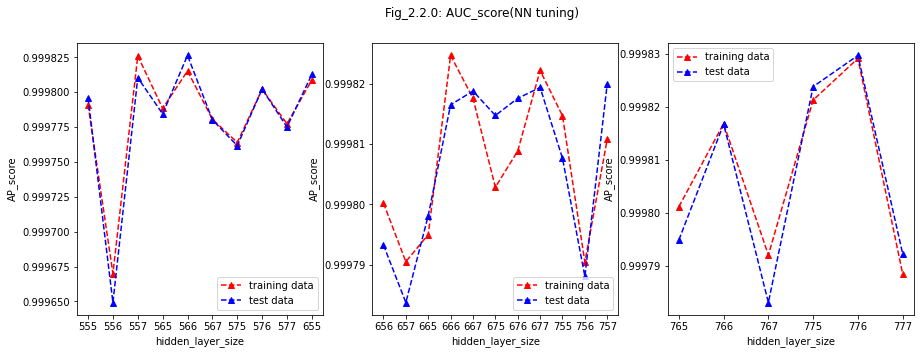

In [8]:
fig_0, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
# axs.plot(hidden_layer_sizes_text,AP_train_score_list,"r^",linestyle = "--",label='training data')
# axs.plot(hidden_layer_sizes_text,AP_test_score_list,"b^",linestyle = "--",label='test data')
axs[0].plot(hidden_layer_sizes_text[:10],AUC_train_score_list[:10],"r^",linestyle = "--",label='training data')
axs[0].plot(hidden_layer_sizes_text[:10],AUC_test_score_list[:10],"b^",linestyle = "--",label='test data')
axs[1].plot(hidden_layer_sizes_text[10:21],AUC_train_score_list[10:21],"r^",linestyle = "--",label='training data')
axs[1].plot(hidden_layer_sizes_text[10:21],AUC_test_score_list[10:21],"b^",linestyle = "--",label='test data')

axs[2].plot(hidden_layer_sizes_text[21:],AUC_train_score_list[21:],"r^",linestyle = "--",label='training data')
axs[2].plot(hidden_layer_sizes_text[21:],AUC_test_score_list[21:],"b^",linestyle = "--",label='test data')
axs[0].set_xlabel("hidden_layer_size")
axs[0].set_ylabel("AP_score")
axs[1].set_xlabel("hidden_layer_size")
axs[1].set_ylabel("AP_score")
axs[2].set_xlabel("hidden_layer_size")
axs[2].set_ylabel("AP_score")
axs[0].legend()
axs[1].legend()
axs[2].legend()
# axs.set_xlabel("hidden_layer_size")
# axs.set_ylabel("AP score")
# axs.legend()
fig_0.suptitle("Fig_2.2.0: AUC_score(NN tuning)")
fig_0.savefig("NN_fig_2.2_tunning:AP_score.png")

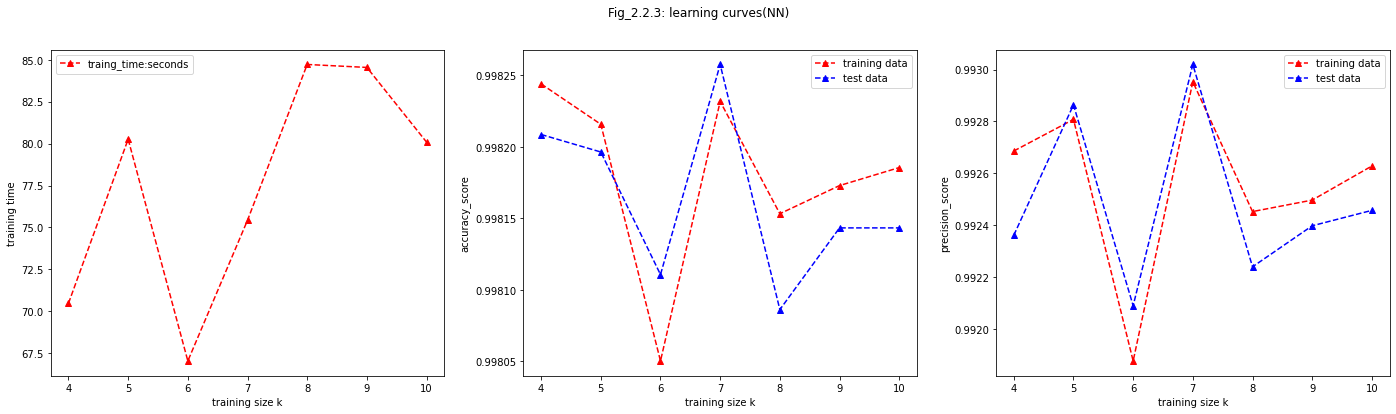

In [13]:
K= range(4,11)
fig_3, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=False)
axs[0].plot(K,training_time,"r^",linestyle = "--",label="traing_time:seconds")
axs[0].set_xlabel("training size k")
axs[0].set_ylabel("training time")
axs[1].plot(K,Accuracy_train_score,"r^",linestyle = "--",label='training data')
axs[1].plot(K,Accuracy_test_score,"b^",linestyle = "--",label='test data')
axs[1].set_xlabel("training size k")
axs[1].set_ylabel("accuracy_score")
axs[2].plot(K,Precision_train_score,"r^",linestyle = "--",label='training data')
axs[2].plot(K,Precision_test_score,"b^",linestyle = "--",label='test data')
axs[2].set_xlabel("training size k")
axs[2].set_ylabel("precision_score")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig_3.suptitle("Fig_2.2.3: learning curves(NN)")
fig_3.savefig("NN_fig_2.2_trainnig:learning curves.png")